In [11]:
from glob import glob
import re
import math
import os
import gc
import cv2

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import tensorflow_hub as hub
%matplotlib inline

L = 16000
legal_labels = 'yes no'.split()
#legal_labels = 'yes no up down left right on off stop go silence unknown'.split()
#src folders
root_path = './'
out_path = r'.'
model_path = r'.'
train_data_path = os.path.join(root_path, 'yesnotrain')
test_data_path = os.path.join(root_path, 'test')

In [12]:
def list_wavs_fname(dirpath, ext='png'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

In [13]:
def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.Series(nlabels)

In [14]:
labels, fnames = list_wavs_fname(train_data_path)
# print(fnames)

./yesnotrain


In [15]:
new_sample_rate = 8000
y_train = []
x_train = []
# a = cv2.imread(os.path.join(train_data_path, labels[0], fnames[0]))

for label, fname in zip(labels, fnames):
        x_train.append(cv2.resize(cv2.imread(os.path.join(train_data_path, label, fname)), dsize=(96,96), interpolation=cv2.INTER_NEAREST))
        y_train.append(label)
x_train = np.array(x_train)
y_train = label_transform(y_train)
# label_index = y_train.columns.values
# y_train = y_train.values
# y_train = np.array(y_train)
del labels, fnames
gc.collect()
print(x_train)


[[[[141  97  51]
   [141  97  51]
   [141 106  47]
   ...
   [139  86  56]
   [142 125  39]
   [141 132  36]]

  [[141 105  47]
   [141 105  47]
   [142 113  44]
   ...
   [142 114  44]
   [141 131  37]
   [141 136  35]]

  [[137  75  61]
   [137  75  61]
   [142 130  37]
   ...
   [141  99  50]
   [142 119  42]
   [142 129  38]]

  ...

  [[141  94  52]
   [141  94  52]
   [142 108  46]
   ...
   [140  93  53]
   [142 116  43]
   [142 122  40]]

  [[141 103  48]
   [141 103  48]
   [142 119  42]
   ...
   [141  95  52]
   [142 122  40]
   [142 126  39]]

  [[142 110  45]
   [142 110  45]
   [142 116  43]
   ...
   [141  96  51]
   [142 122  40]
   [142 127  38]]]


 [[[ 84   1  68]
   [ 84   1  68]
   [ 84   1  68]
   ...
   [139  83  58]
   [140 146  31]
   [138 151  30]]

  [[ 84   1  68]
   [ 84   1  68]
   [ 84   1  68]
   ...
   [139  84  57]
   [139 148  31]
   [138 153  30]]

  [[ 84   1  68]
   [ 84   1  68]
   [ 84   1  68]
   ...
   [139  86  56]
   [139 149  31]
   [138 153

In [16]:
labels_dict = {}
i = 0
for k in legal_labels:
    labels_dict[k] = i
    i += 1
print(labels_dict)

{'no': 1, 'yes': 0}


In [17]:
print(y_train)
#labels_dict = {"yes":0, "no":1, "up":2, "down":3, "left":4, "right":5, "on":6, "off":7, "stop":8, "go":9, "silence":10, "unknown":11}
for i, elem in enumerate(y_train):
    y_train[i] = labels_dict[y_train[i]]
y_train = np.array(y_train).astype(int)
print(y_train.astype(int))

0        no
1        no
2        no
3        no
4        no
5        no
6        no
7        no
8        no
9        no
10       no
11       no
12       no
13       no
14       no
15       no
16       no
17       no
18       no
19       no
20       no
21       no
22       no
23       no
24       no
25       no
26       no
27       no
28       no
29       no
       ... 
4722    yes
4723    yes
4724    yes
4725    yes
4726    yes
4727    yes
4728    yes
4729    yes
4730    yes
4731    yes
4732    yes
4733    yes
4734    yes
4735    yes
4736    yes
4737    yes
4738    yes
4739    yes
4740    yes
4741    yes
4742    yes
4743    yes
4744    yes
4745    yes
4746    yes
4747    yes
4748    yes
4749    yes
4750    yes
4751    yes
Length: 4752, dtype: object
[1 1 1 ... 0 0 0]


In [18]:
y = pd.Series(y_train)
y.value_counts()

0    2377
1    2375
dtype: int64

In [19]:
#shuffle the data
s = np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train = x_train[s]
y_train = y_train[s]

In [20]:
train_data = x_train[:5000,:]
train_labels = y_train[:5000]
print(train_data.shape)
print(train_labels.shape)
print(pd.Series(train_labels).value_counts())

(4752, 96, 96, 3)
(4752,)
0    2377
1    2375
dtype: int64


In [21]:
eval_data = x_train[-2000:,:]
eval_labels = y_train[-2000:]
print(eval_data.shape)
print(eval_labels.shape)

(2000, 96, 96, 3)
(2000,)


In [27]:
train_data = train_data.astype('float32')
eval_data = eval_data.astype('float32')

In [28]:
def mobilenet_model_fn(features, labels, mode):
    # Load Inception-v3 model.
    module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/feature_vector/2")
    input_layer = features["images"]
    outputs = module(input_layer)

    logits = tf.layers.dense(inputs=outputs, units=2)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [29]:
# def construct_feature_columns():
#   # There are 784 pixels in each image.
#   return set([tf.feature_column.numeric_column('pixels', shape=784)])

In [30]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
#   """A custom input_fn for sending MNIST data to the estimator for training.
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': features}, y=labels,
        batch_size=batch_size, num_epochs=None, shuffle=True)
    return input_fn

In [31]:
def create_predict_input_fn(features, batch_size):
    """A custom input_fn for sending mnist data to the estimator for predictions.
    """
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {'images': features},
        batch_size=batch_size,
        shuffle=False)
    return predict_input_fn

In [32]:
def train_hub_classification_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
        
    periods = 10

    steps_per_period = steps / periods  
    predict_training_input_fn = create_predict_input_fn(
        training_examples, 
        batch_size)
    predict_validation_input_fn = create_predict_input_fn(
        validation_examples, 
        batch_size)
    training_input_fn = create_training_input_fn(
        training_examples, 
        training_targets, 
        batch_size)

    classifier = tf.estimator.Estimator(
    model_fn=mobilenet_model_fn
        , model_dir="./model/"
        )

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['classes'] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,2)

        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['classes'] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,2)    

        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['classes'] for item in final_predictions])


    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_task_id': 0, '_keep_checkpoint_max': 5, '_master': '', '_num_ps_replicas': 0, '_global_id_in_cluster': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f14928cab70>, '_service': None, '_session_config': None, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_model_dir': '/tmp/tmpx28ahsvy', '_num_worker_replicas': 1, '_train_distribute': None, '_task_type': 'worker', '_tf_random_seed': None, '_is_chief': True, '_evaluation_master': ''}
Training model...
LogLoss error (on validation data):
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilen

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv_1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab60

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpx28ahsvy/model.ckpt-30
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_c

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilen

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv_1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab60

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpx28ahsvy/model.ckpt-60
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_c

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilen

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv_1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab60

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpx28ahsvy/model.ckpt-90
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_c

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_12/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_3/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_2/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/3ab6027928265cfdfe0b88b4e2f3eda811117d45/variables/variables' with MobilenetV2/expanded_conv_9/dept

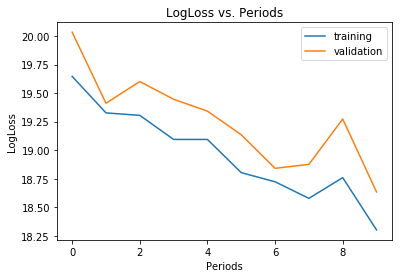

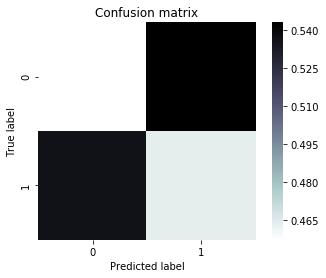

In [33]:
classifier = train_hub_classification_model(
    learning_rate=0.05,
    steps=100,
    batch_size=30,
    training_examples=train_data,
    training_targets=train_labels,
    validation_examples=eval_data,
    validation_targets=eval_labels)